In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import utils as ut

system_name = 'kite3d_turbo'
run_name = 'norail2'
data_dir = '../data/' + system_name + '/' + run_name + '/'
plot_dir = '../plots/'+system_name+'/'+run_name+'/'

In [2]:
names_list = ['kite2d', 'kite3d', 'kite2d_vrel', 'kite3d_vrel', 'kite3d_lin', 'kite3d_couetteframe', 'kite3d_turbo']
if system_name not in names_list:
    print('Warning: invalid system name')

## Environment

### General parameters

In [3]:
env_params = dict()

# TIME
env_params['int_steps'] = 0.001 # sec
env_params['ep_length'] = 200 # sec
env_params['ep_length_eval'] = 600 # sec
env_params['decision_time'] = 0.25 # sec

# ATTACK ANGLE
env_params['alphas'] =    [6,    8,    10,   12,  14,   16,   18,   20]
env_params['CL_alphas'] = [0.65, 0.75, 0.82, 0.9, 1.0,  1.08, 1.1,  1.05]
env_params['CD_alphas'] = [0.05, 0.07, 0.09, 0.1, 0.13, 0.18, 0.18, 0.21]
#env_params['alphas'] =    [18,   20]
#env_params['CL_alphas'] = [1.1,  1.05]
#env_params['CD_alphas'] = [0.18, 0.21]

# INIT COND
env_params['init_theta'] = np.pi/3 # rad
env_params['init_dtheta'] = 0 # rad/s
env_params['init_alpha'] = len(env_params['alphas'])-1 # index, if larger than len it's random

### Specific params

In [4]:
# RELATIVE VELOCITY AS OBSERVABLE
if system_name != 'kite2d' and system_name != 'kite3d':
    env_params['beta_bins'] = np.linspace(-np.pi/2, np.pi/2, 10)
    
# 3D KITE
if system_name != 'kite2d' and system_name != 'kite2d_vrel':

    # BANK ANGLES
    env_params['banks'] = np.deg2rad([-15,-12,-9,-6,-3,0,3,6,9,12,15])
  
    # INIT COND
    env_params['init_bank'] = int(len(env_params['banks'])//2) # index, if larger than len it's random
    env_params['init_phi'] = 0 # rad
    env_params['init_dphi'] = 0 # rad
    #env_params['init_xblock'] = 0 # m
    #env_params['init_yblock'] = 0 # m

### Wind

In [5]:
# CONSTANT WIND
if system_name == 'kite2d' or system_name == 'kite3d' or system_name == 'kite3d_vrel':
    env_params['wind_type'] = 'const' # 'const' for constant, 'stream' for the stream function
    env_params['v_wind_x'] = 12 # m/sec
    env_params['v_wind_y'] = 0 # m/sec
    env_params['v_wind_z'] = 0 # m/sec
    
# 2D STREAM FUNCTION
elif system_name == 'kite2d_vrel':
    env_params['wind_type'] = 'stream'
    env_params['k_wind'] = 0.5 # 1/sec
    env_params['eps_wind'] = 0.2
    
# LINEAR PROFILE
elif system_name == 'kite3d_lin':
    env_params['wind_type'] = 'lin'
    env_params['v_ground'] = 8 # 1/sec
    env_params['v_ang_coef'] = 0.14
    
# TURBULENT FRAME
elif system_name == 'kite3d_couetteframe':
    env_params['wind_type'] = 'turboframe'
    env_params['wind_amplification'] = 1
    env_params['windv_file_path'] = "../data/kite3d_couetteframe/v.txt"
    env_params['windq_file_path'] = "../data/kite3d_couetteframe/q.txt"

# TURBULENCE
elif system_name == 'kite3d_turbo':
    env_params['wind_type'] = 'turbo'
    env_params['wind_amplification'] = 1
    env_params['windv_file_dir'] = '../data/kite3d_turbo/v1/'
    env_params['windv_file_name'] = 'velocities'
    env_params['windq_file_path'] = '../data/kite3d_turbo/q.txt'
    env_params['start_frame'] = 1000

else:
    print('Invalid environment')

## Algorithm

### Algorithm type

In [6]:
alg_params = dict()
alg_params['alg_type'] = 'sarsa'

if alg_params['alg_type'] == 'et':
    alg_params['lambda'] = 0.9 # Specific of eligibity traces

if alg_params['alg_type'] not in ['sarsa', 'ac', 'nac', 'et']:
    print('Warning: invalid system name')

### General parameters

In [7]:
# DISC FACTOR
alg_params['gamma'] = 1.0

# TIME
alg_params['n_steps'] = 600000000 # Number of training steps
print('Seconds of learning: ', alg_params['n_steps']*env_params['decision_time'])
alg_params['traj_points'] = 1000

# LEARNING RATE
alg_params['lr0'] = 0.1
alg_params['lr1'] = 0.01
alg_params['n0'] = 10000;
alg_params['lrc'] = alg_params['n_steps'] / 150
alg_params['lr_expn'] = 0.6
alg_params['lr_burn0'] = alg_params['n_steps'] * 0.5
alg_params['lr_burn1'] = alg_params['n_steps'] * 0.5

# EXPLORATION
alg_params['eps0'] = 0.01
alg_params['epsc'] = alg_params['n_steps'] / 150
alg_params['eps_expn'] = 1
alg_params['eps_burn'] = alg_params['n_steps'] / 3

Seconds of learning:  150000000.0
Seconds of evaluation:  0.0


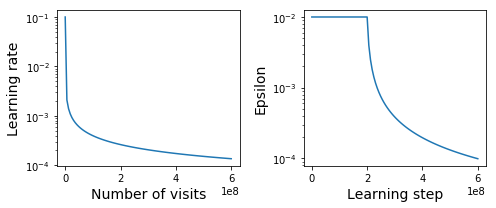

In [8]:
fig, (ax1, ax2) = ut.plot_lr_eps_2state(alg_params)
plt.tight_layout()
plt.savefig(plot_dir+'lr_steps.png', dpi=200)
plt.show()

In [8]:
# INITIAL CONDITIONS
# Comment 'init_q_path' for a flat policy
#alg_params['init_q_path'] = '../data/' + system_name + '/short600/best_quality.txt' 
# If 'init_q_path' is present, 'init_quals' is ignored
alg_params['init_quals'] = 3000

In [9]:
# WRITING THE PARAMETERS
ut.write_params(env_params, data_dir, "param_env.txt")
ut.write_params(alg_params, data_dir, "param_alg.txt")